In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity


In [4]:
df = pd.read_csv("data.csv", encoding="latin1")

print(df.head())
print(df.columns)


  stn_code       sampling_date           state   location agency  \
0    150.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
1    151.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
2    152.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
3    150.0     March - M031990  Andhra Pradesh  Hyderabad    NaN   
4    151.0     March - M031990  Andhra Pradesh  Hyderabad    NaN   

                                 type  so2   no2  rspm  spm  \
0  Residential, Rural and other Areas  4.8  17.4   NaN  NaN   
1                     Industrial Area  3.1   7.0   NaN  NaN   
2  Residential, Rural and other Areas  6.2  28.5   NaN  NaN   
3  Residential, Rural and other Areas  6.3  14.7   NaN  NaN   
4                     Industrial Area  4.7   7.5   NaN  NaN   

  location_monitoring_station  pm2_5        date  
0                         NaN    NaN  1990-02-01  
1                         NaN    NaN  1990-02-01  
2                         NaN    NaN  1990-02-01  
3       

/tmp/ipython-input-3033514514.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv", encoding="latin1")


In [5]:
x = df['no2'].dropna()

# convert to numeric safely
x = pd.to_numeric(x, errors='coerce').dropna()

x = x.values

print("Shape of x:", x.shape)
print("First 5 values:", x[:5])


Shape of x: (419509,)
First 5 values: [17.4  7.  28.5 14.7  7.5]


In [6]:
r = 102303289

a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

print("a_r =", a_r)
print("b_r =", b_r)


a_r = 2.0
b_r = 1.5


In [7]:
z = x + a_r * np.sin(b_r * x)

print("Shape of z:", z.shape)
print("First 5 transformed values:", z[:5])


Shape of z: (419509,)
First 5 transformed values: [19.046666    5.24060848 26.61349178 14.58236508  5.564384  ]


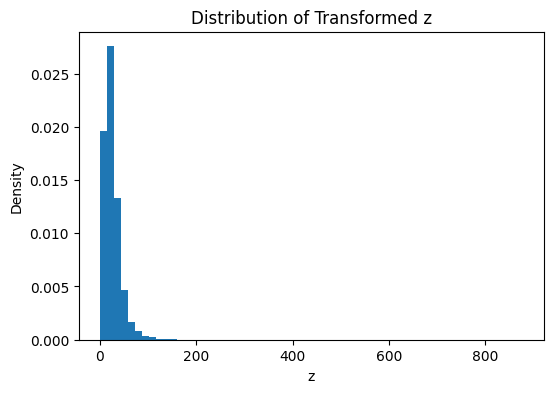

In [8]:
plt.figure(figsize=(6,4))
plt.hist(z, bins=60, density=True)
plt.title("Distribution of Transformed z")
plt.xlabel("z")
plt.ylabel("Density")
plt.show()


In [11]:
scaler = StandardScaler()
z_scaled = scaler.fit_transform(z.reshape(-1,1))

print("Mean after scaling:", z_scaled.mean())
print("Std after scaling:", z_scaled.std())


Mean after scaling: 3.457956919464947e-16
Std after scaling: 1.0


In [12]:
z_tensor = torch.tensor(z_scaled, dtype=torch.float32)

print(z_tensor.shape)


torch.Size([419509, 1])


In [14]:
class Generator(nn.Module):
    def __init__(self, noise_dim=5):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(noise_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

noise_dim = 5
G = Generator(noise_dim)

print(G)


Generator(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

D = Discriminator()

print(D)


Discriminator(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [17]:
criterion = nn.BCELoss()

optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002)

In [18]:
epochs = 5000
batch_size = 128

for epoch in range(epochs):

    idx = np.random.randint(0, z_tensor.shape[0], batch_size)
    real_data = z_tensor[idx]

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    noise = torch.randn(batch_size, noise_dim)
    fake_data = G(noise)

    D_real = D(real_data)
    D_fake = D(fake_data.detach())

    loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

    optimizer_D.zero_grad()
    loss_D.backward()
    optimizer_D.step()

    noise = torch.randn(batch_size, noise_dim)
    fake_data = G(noise)

    D_fake = D(fake_data)
    loss_G = criterion(D_fake, real_labels)

    optimizer_G.zero_grad()
    loss_G.backward()
    optimizer_G.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")


Epoch 0 | D Loss: 1.3957 | G Loss: 0.6187
Epoch 500 | D Loss: 1.3672 | G Loss: 0.6965
Epoch 1000 | D Loss: 1.1116 | G Loss: 0.9413
Epoch 1500 | D Loss: 1.4471 | G Loss: 0.5993
Epoch 2000 | D Loss: 1.3870 | G Loss: 0.7295
Epoch 2500 | D Loss: 1.3838 | G Loss: 0.6916
Epoch 3000 | D Loss: 1.3805 | G Loss: 0.7080
Epoch 3500 | D Loss: 1.3781 | G Loss: 0.7040
Epoch 4000 | D Loss: 1.3564 | G Loss: 0.7207
Epoch 4500 | D Loss: 1.4023 | G Loss: 0.7027


In [20]:
noise = torch.randn(50000, noise_dim)
fake_samples = G(noise).detach().numpy()

fake_samples = scaler.inverse_transform(fake_samples)
real_samples = scaler.inverse_transform(z_scaled)

In [21]:
kde_real = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(real_samples)
kde_fake = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(fake_samples)

x_range = np.linspace(real_samples.min(), real_samples.max(), 1000).reshape(-1,1)

log_real = kde_real.score_samples(x_range)
log_fake = kde_fake.score_samples(x_range)


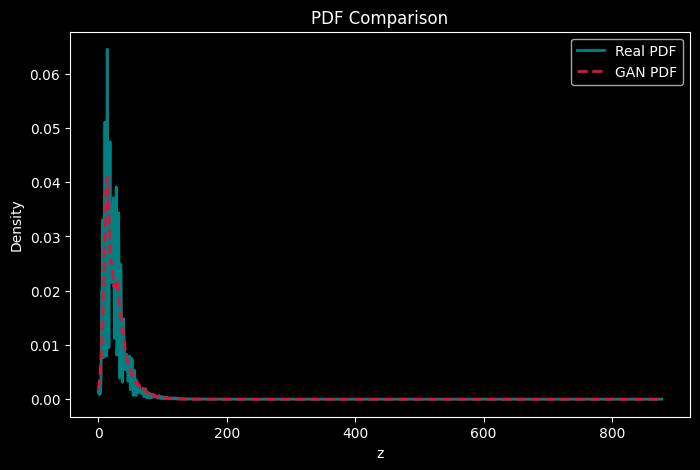

In [30]:
plt.figure(figsize=(8,5))

plt.plot(x_range, np.exp(log_real),
         color="teal", linewidth=2, label="Real PDF")

plt.plot(x_range, np.exp(log_fake),
         color="crimson", linewidth=2, linestyle="--", label="GAN PDF")

plt.legend()
plt.title("PDF Comparison")
plt.xlabel("z")
plt.ylabel("Density")
plt.savefig("pdf_comparison.png", dpi=300)
plt.show()


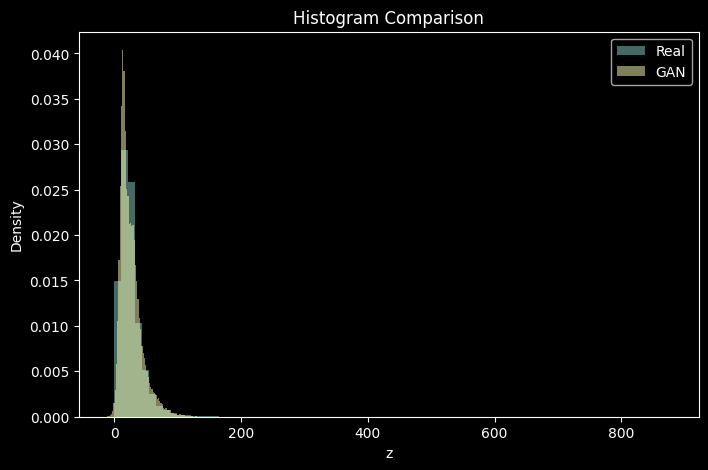

In [31]:
plt.figure(figsize=(8,5))

plt.hist(real_samples, bins=80, density=True, alpha=0.5, label="Real")
plt.hist(fake_samples, bins=80, density=True, alpha=0.5, label="GAN")

plt.legend()
plt.title("Histogram Comparison")
plt.xlabel("z")
plt.ylabel("Density")

plt.savefig("histogram_comparison.png", dpi=300)
plt.show()


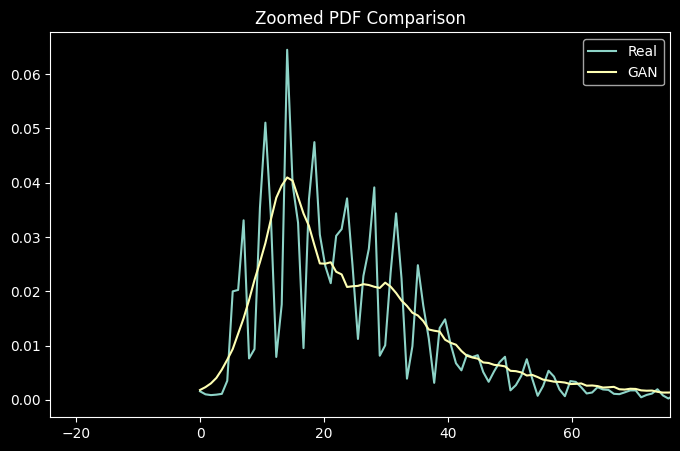

In [32]:
plt.figure(figsize=(8,5))
plt.plot(x_range, np.exp(log_real), label="Real")
plt.plot(x_range, np.exp(log_fake), label="GAN")

plt.xlim(real_samples.mean()-50, real_samples.mean()+50)
plt.legend()
plt.title("Zoomed PDF Comparison")

plt.savefig("zoomed_pdf_comparison.png", dpi=300)
plt.show()


In [29]:
print("Real Mean:", real_samples.mean())
print("Fake Mean:", fake_samples.mean())

print("Real Std:", real_samples.std())
print("Fake Std:", fake_samples.std())


Real Mean: 25.877148059579433
Fake Mean: 26.23158
Real Std: 18.486493065326027
Fake Std: 17.239235
